In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import duckdb

In [2]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

In [3]:
conn = duckdb.connect("../data/processed/nba.duckdb")

In [4]:
sql = """
WITH PROP_STATS AS (
SELECT 
	b.SEASON_YEAR,
	a.TEAM_ABBREVIATION,
	a.GAME_ID,
	a.PLAYER_NAME,
	(a.PTS::FLOAT / b.PTS::FLOAT) AS PROP_PTS,
	(a.AST::FLOAT / b.AST::FLOAT) AS PROP_AST,
	(a.REB::FLOAT / b.REB::FLOAT) AS PROP_REB
FROM players.tb_boxscore AS a
INNER JOIN teams.tb_game_logs AS b ON a.TEAM_ID = b.TEAM_ID AND a.GAME_ID = b.GAME_ID
)
SELECT 
	SEASON_YEAR,
	TEAM_ABBREVIATION,
	GAME_ID,
	SUM(PROP_PTS**2) AS HHI_PTS,
	SUM(PROP_AST**2) AS HHI_AST,
	SUM(PROP_REB**2) AS HHI_REB
FROM PROP_STATS
WHERE SEASON_YEAR = '2021-22'
GROUP BY SEASON_YEAR, TEAM_ABBREVIATION, GAME_ID
"""

balanced_stats = conn.execute(sql).fetch_df()

In [5]:
balanced_stats.head()

,SEASON_YEAR,TEAM_ABBREVIATION,GAME_ID,HHI_PTS,HHI_AST,HHI_REB
0,2021-22,HOU,0022100916,0.134527,0.213018,0.143901
1,2021-22,DET,0022100915,0.155930,0.144444,0.131687
2,2021-22,CHA,0022100915,0.172965,0.171200,0.137996
3,2021-22,CHA,0022100924,0.145781,0.206612,0.110000
4,2021-22,MIL,0022100924,0.130769,0.196800,0.135796


<AxesSubplot: xlabel='HHI_PTS', ylabel='Count'>

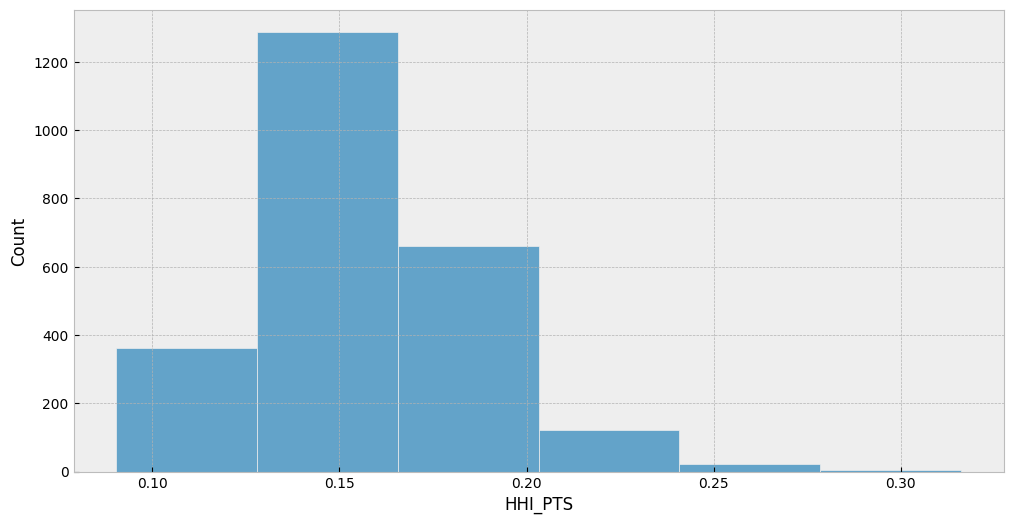

In [6]:
sns.histplot(x="HHI_PTS", data=balanced_stats, bins=6)

In [20]:
teams_idx, teams = pd.factorize(balanced_stats["TEAM_ABBREVIATION"], sort=True)

with pm.Model(coords={"teams": teams}) as model:
    # hyperpriors
    
    # priors
    mu = pm.Uniform("mu", lower=0, upper=1, dims="teams")
    sigma = pm.HalfNormal("sigma", sigma=1, dims="teams")
    # likelihood
    pts = pm.Normal("pts", mu=mu[teams_idx], sigma=sigma[teams_idx], observed=balanced_stats["HHI_REB"])
    
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


In [21]:
az.summary(samples, var_names=["mu"]).sort_values("mean")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[GSW],0.136,0.002,0.132,0.139,0.0,0.0,4998.0,1466.0,1.00
mu[MEM],0.138,0.002,0.133,0.142,0.0,0.0,3906.0,1394.0,1.00
mu[OKC],0.142,0.003,0.137,0.148,0.0,0.0,3336.0,1482.0,1.00
mu[LAC],0.143,0.002,0.139,0.148,0.0,0.0,4969.0,1656.0,1.00
mu[BKN],0.145,0.003,0.140,0.150,0.0,0.0,3599.0,1405.0,1.00
mu[CHA],0.147,0.003,0.142,0.152,0.0,0.0,5259.0,1323.0,1.00
mu[DAL],0.148,0.003,0.143,0.153,0.0,0.0,4292.0,1255.0,1.00
mu[SAS],0.149,0.003,0.144,0.155,0.0,0.0,3889.0,1627.0,1.00
mu[DET],0.149,0.003,0.144,0.154,0.0,0.0,3205.0,1269.0,1.00
mu[WAS],0.150,0.003,0.144,0.155,0.0,0.0,4564.0,1296.0,1.00


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

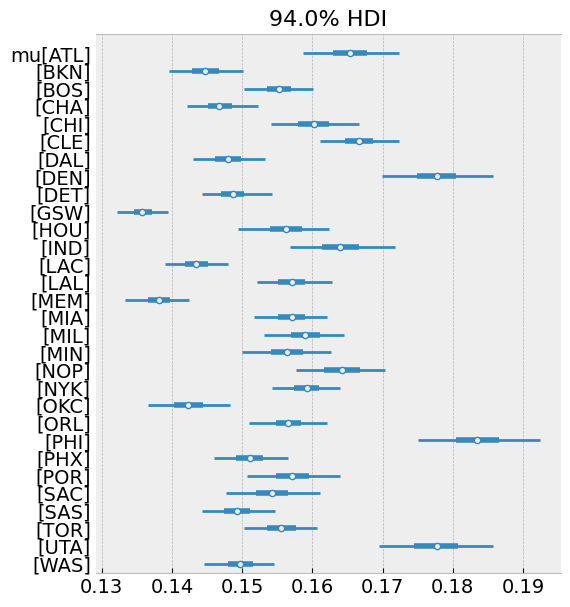

In [22]:
az.plot_forest(samples, combined=True, var_names=["mu"])

In [29]:
conn.close()